## Домашняя работа №7

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH.
Библиотеки: [Python, Tensorflow].

### Загрузка и подключение библиотек

In [1]:
%tensorflow_version 2.x

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

### Загрузка и распаковка датасета KTH

In [5]:
if 0:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

In [6]:
if 0:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

### Подготовка датасета для классификации

In [7]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [8]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 180


### Визуализация кадра из видео

videodata shape: (492, 120, 160, 3)


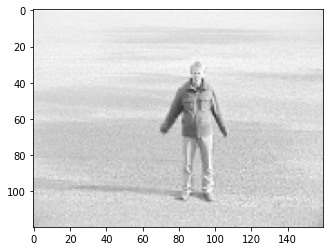

In [9]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[30, ...])

### Визуализация "движения"

motion shape: (491, 120, 160, 1)


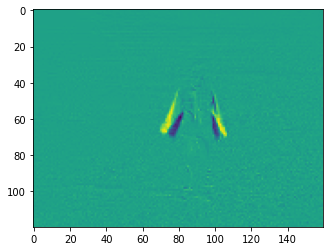

In [10]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[30, ..., 0])

### Создание модели CNN

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(16, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(32, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(32, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [12]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

In [13]:
%%time

global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/10][0/180] Loss = 1.791678786277771
[0/10][10/180] Loss = 1.8097084760665894
[0/10][20/180] Loss = 1.785921335220337
[0/10][30/180] Loss = 1.8129844665527344
[0/10][40/180] Loss = 1.8006747961044312
[0/10][50/180] Loss = 1.7809585332870483
[0/10][60/180] Loss = 1.7747797966003418
[0/10][70/180] Loss = 1.7871646881103516
[0/10][80/180] Loss = 1.754711627960205
[0/10][90/180] Loss = 1.7006456851959229
[0/10][100/180] Loss = 1.769063115119934
[0/10][110/180] Loss = 1.4277141094207764
[0/10][120/180] Loss = 1.7810057401657104
[0/10][130/180] Loss = 1.8419528007507324
[0/10][140/180] Loss = 1.6512575149536133
[0/10][150/180] Loss = 1.7496657371520996
[0/10][160/180] Loss = 2.4956445693969727
[0/10][170/180] Loss = 1.7868385314941406
[1/10][0/180] Loss = 1.0538020133972168
[1/10][10/180] Loss = 2.0934414863586426
[1/10][20/180] Loss = 1.0001652240753174
[1/10][30/180] Loss = 1.783062219619751
[1/10][40/180] Loss = 1.059777855873108
[1/10][50/180] Loss = 1.9030064344406128
[1/10][60/180] L

### Тестирование обученной модели

In [14]:
def prediction():
    fpath, cls_true = random.choice(dataset)

    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    plt.imshow(videodata[30, ...])

    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

    out = model(motion[None, ...])[0]
    cls_pred = np.argmax(out.numpy())

    print('True class:', classes[cls_true])
    print('Predicted class:', classes[cls_pred])

True class: handclapping
Predicted class: handclapping


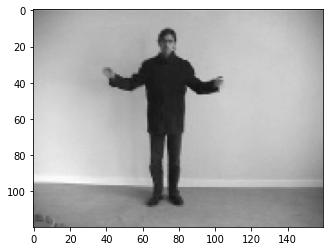

In [15]:
prediction()

True class: handclapping
Predicted class: handclapping


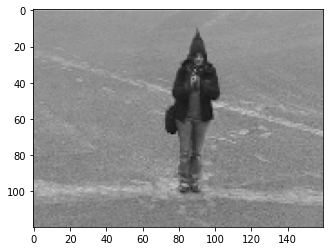

In [16]:
prediction()

True class: jogging
Predicted class: walking


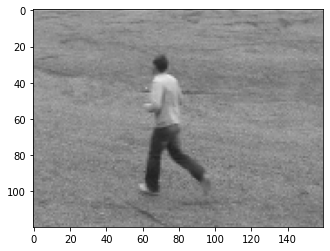

In [17]:
prediction()

True class: boxing
Predicted class: boxing


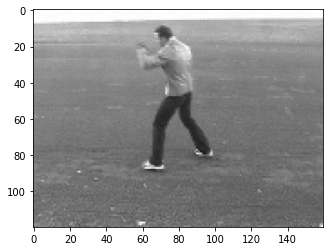

In [18]:
prediction()

True class: jogging
Predicted class: jogging


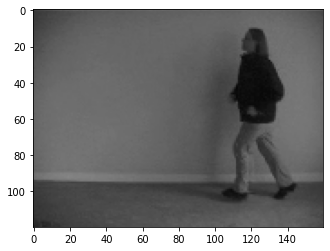

In [19]:
prediction()

True class: running
Predicted class: running


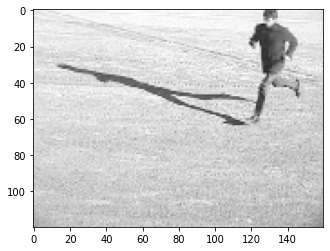

In [20]:
prediction()

True class: handclapping
Predicted class: handclapping


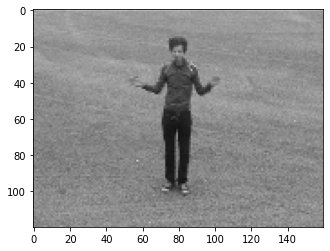

In [21]:
prediction()

True class: running
Predicted class: running


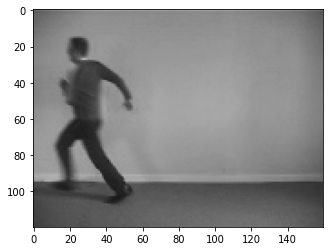

In [22]:
prediction()